[View in Colaboratory](https://colab.research.google.com/github/clee1994/DLclass/blob/master/HW_TensorFlow_with_GPU.ipynb)

# Confirm TensorFlow can see the GPU

Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [59]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sys
import time
import pandas as pd

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [0]:
def gen_matrix(rows, cols, rank, percent_missing):

   
  #initialize
  A = np.random.randn(rows,rank)*100
  B = np.random.randn(rank,cols)*100
  C_orig = np.dot(A,B)
  C_masked = C_orig.copy()
  
  #for np mask purpose
  C_masked.ravel()[np.random.choice(C_orig.size, int(C_orig.size*percent_missing), replace=False)] = np.nan
  C_masked_df = pd.DataFrame(C_masked)
  np_mask = C_masked_df.notnull()
  
  C_orig = np.array(C_orig,dtype=np.float32).T
  C_orig_df = pd.DataFrame(C_orig)
   
  
  tf_mask = tf.Variable(np_mask.values)
  C = tf.constant(C_orig_df.values)

  
  shape = C_orig_df.values.shape

  # Initializing random H and W
  temp_H = np.random.randn(rank, shape[1]).astype(np.float32)
  #temp_H = np.divide(temp_H, temp_H.max())

  temp_W = np.random.randn(shape[0], rank).astype(np.float32)
  #temp_W = np.divide(temp_W, temp_W.max())
  
  return temp_H, temp_W, C, tf_mask








In [0]:
def matcompl_grad(rows, cols, rank, percent_missing, lr, steps):
  
  #config = tf.ConfigProto()
  #config.gpu_options.allow_growth = True
  
  
  #with tf.device('/gpu:0'):
  
  #for i in range(50):
  temp_H, temp_W, B, tf_mask = gen_matrix(rows, cols, rank, percent_missing)
  print(temp_H)
  print(temp_W)

  H =  tf.Variable(temp_H)
  W = tf.Variable(temp_W)
  WH = tf.matmul(W, H)

  cost = tf.reduce_sum(tf.pow(tf.boolean_mask(B, tf_mask) - tf.boolean_mask(WH, tf_mask), 2))
  accuracy = tf.reduce_sum(tf.pow(tf.boolean_mask(B, tf.logical_not(tf_mask)) - tf.boolean_mask(WH, tf.logical_not(tf_mask)), 2))

  train_step = tf.train.GradientDescentOptimizer(lr).minimize(cost)
  init = tf.global_variables_initializer()

  cost_hist = pd.DataFrame({'cost':[],'time':[]})
   
  with tf.Session() as sess:
      sess.run(init)
      start_time = time.time()
      for i in range(steps):
          sess.run(train_step)
          #sess.run(clip)
          if i%10==0:
            print("\nCost: %f" % sess.run(cost))
            #print("*"*40)
          if i == 1:
            print(sess.run(W))
            print(sess.run(H))
            print(sess.run(WH))
            print(sess.run(B))
          new_entry = pd.DataFrame({'cost':[sess.run(cost)],'time':[time.time() - start_time]})
          cost_hist.append(new_entry)
          
      learnt_W = sess.run(W)
      learnt_H = sess.run(H)

  plt.scatter(cost_hist['cost'],cost_hist['time'])
  #plt.set('Cost')
  #plt.set_xlabel('Time')
  #fig.set_title(title_str)
  #fig.legend(handle, "Gradient Descent")
  plt.show()
      
    
    
    


In [0]:
def matcompl_sgd(rows, cols, rank, percent_missing, lr, steps, fig,title_str):
  
  batch_size = 128
  
  temp_H, temp_W, B, tf_mask,np_mask = gen_matrix(rows, cols, rank, percent_missing)

 

  H =  tf.Variable(temp_H)
  W = tf.Variable(temp_W)
  WH = tf.matmul(W, H)
  
  
  #first sample -> maybe not necessary
  sample_m = np.ones((rows,cols))
  sample_m.ravel()[np.random.choice(sample_m.size, sample_m.size-batch_size, replace=False)] = np.nan
  sample_m = pd.DataFrame(sample_m)
  sample_mask = sample_m.notnull()
  #tf_sample_mask = tf.Variable(sample_mask.values)
  
  full_mask = tf.Variable(sample_mask.values & np_mask.values)
  
  cost = tf.reduce_sum(tf.pow(tf.boolean_mask(B, full_mask) - tf.boolean_mask(WH, full_mask), 2))
  
  train_step = tf.train.GradientDescentOptimizer(lr).minimize(cost)
  init = tf.global_variables_initializer()

  cost_hist = []

  with tf.Session() as sess:
      sess.run(init)
      for i in range(steps):
        
        
          #sample
          sample_m = np.ones((rows,cols))
          sample_m.ravel()[np.random.choice(sample_m.size, sample_m.size-batch_size, replace=False)] = np.nan
          sample_m = pd.DataFrame(sample_m)
          sample_mask = sample_m.notnull()
          #tf_sample_mask = tf.Variable(sample_mask.values)
          full_mask = tf.Variable(sample_mask.values & np_mask.values)
        
          #print(full_mask.eval())
          #print(sample_mask)
          #print(np_mask)
          #print("here")
          #print(np.logical_or(sample_mask.values, np_mask.values))
        
          sess.run(train_step)
          #sess.run(clip)
          if i%100==0:
              print("\nCost: %f" % sess.run(cost))
              sys.stdout.flush()
              #print("*"*40)
          cost_hist.append(sess.run(cost))
      learnt_W = sess.run(W)
      learnt_H = sess.run(H)

  
  handle = fig.plot(cost_hist)
  fig.set_ylabel('Cost')
  fig.set_xlabel('Iterations')
  fig.set_title(title_str)
  fig.legend(handle, "SGD")
  #plt.show()
      

In [0]:



def graphs_learning(percent_m, rank, steps):

  # Learning rate
  #global_step = tf.Variable(0, trainable=False)
  #lr = tf.train.exponential_decay(0.01, global_step, 10000, 0.96, staircase=True)

  #alternative
  lr = 0.001

  f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2)

  axes_list = [ax1,ax2,ax3,ax4]

  for i in range(1,4):
    print(str(10**i))
    rows = 10**i
    cols = 10**i
    matcompl_grad(rows, cols, rank, percent_m, lr, steps, axes_list[i-1],str(cols))
    matcompl_sgd(rows, cols, rank, percent_m, lr, steps, axes_list[i-1],str(cols))

  plt.suptitle((str(percent_m)+"%"))
  plt.tight_layout()
  f.show()

[[ 0.7044198   1.405744   -1.2049845  -1.1366535   0.10442507 -0.23869435
  -0.41333798 -0.11573671  0.2766676  -1.9387435 ]
 [ 1.9354178  -0.11124944  1.3108699   0.3284623   0.85407716  1.592775
  -1.1468208  -1.0317616   0.44711658 -1.1376579 ]
 [ 0.2564486   0.15828851 -0.01669494  0.05529874 -1.1191016  -1.7342248
  -0.857499   -0.8019819  -0.2963318   0.4459132 ]
 [ 0.6446317  -0.24260063  0.9898702   0.6004457  -0.09436299  0.75118387
  -1.0708077  -0.61480176  0.33538893  0.11867604]]
[[-1.7194672   1.714014   -0.05249702  1.2684594 ]
 [ 0.08626644 -1.3389322  -0.546748    0.47646677]
 [-0.94035727 -0.78237045 -1.1230692   1.2959101 ]
 [ 0.9171297   0.7184233  -0.7691723   1.9633938 ]
 [-0.89361864 -0.07039329  1.7385789   0.82877755]
 [-0.33515596 -0.4870692   1.6006738  -0.06045371]
 [ 0.03627402  1.151694   -0.32328925 -0.20492649]
 [ 0.5824351   1.0217662  -0.5005651  -0.541687  ]
 [-0.06735896 -0.48995212 -1.7056715   0.43176103]
 [-0.71101344 -0.14762805  0.06846098 -0.58

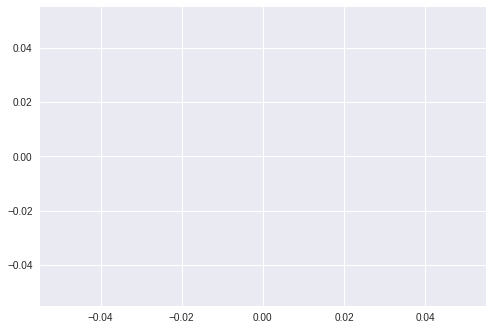

In [86]:
matcompl_grad(10, 10, 4, 0.2, 0.05, 1000)

10

Cost: 105.989059

Cost: 99.897293

Cost: 94.826859

Cost: 90.453156

Cost: 86.562386

Cost: 83.010681

Cost: 79.700539

Cost: 76.566605

Cost: 73.566360

Cost: 70.673752

Cost: 67.874420

Cost: 65.162048

Cost: 62.535431

Cost: 59.996193

Cost: 57.547050

Cost: 55.190689

Cost: 52.929005

Cost: 50.762817

Cost: 48.691799

Cost: 46.714622

Cost: 44.829136

Cost: 43.032589

Cost: 41.321846

Cost: 39.693546

Cost: 38.144218

Cost: 36.670376

Cost: 35.268578

Cost: 33.935486

Cost: 32.667850

Cost: 31.462559

Cost: 30.316635

Cost: 29.227261

Cost: 28.191765

Cost: 27.207664

Cost: 26.272654

Cost: 25.384621

Cost: 24.541630

Cost: 23.741922

Cost: 22.983889

Cost: 22.266052

Cost: 21.587019

Cost: 20.945450

Cost: 20.340040

Cost: 19.769470

Cost: 19.232391

Cost: 18.727419

Cost: 18.253111

Cost: 17.807985

Cost: 17.390511

Cost: 16.999134

Cost: 17.962179

Cost: 15.920763

Cost: 14.302213

Cost: 12.982395

Cost: 11.881220

Cost: 10.944911

Cost: 10.136137

Cost: 9.428205

Cost: 8.80

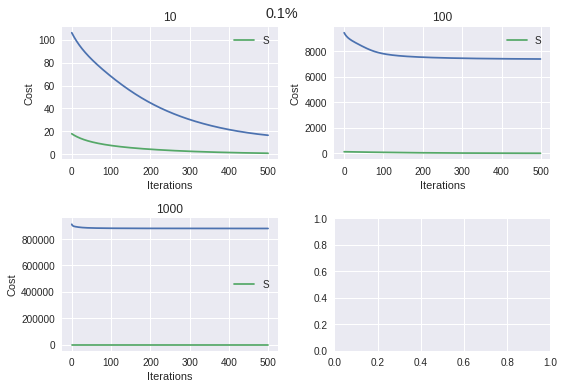

In [8]:
graphs_learning(.1, 5, 500)


10

Cost: 136.656586

Cost: 114.256218

Cost: 99.065430

Cost: 87.871399

Cost: 79.085632

Cost: 71.842445

Cost: 65.640808

Cost: 60.181103

Cost: 55.281830

Cost: 50.833107

Cost: 46.768669

Cost: 43.048244

Cost: 39.646259

Cost: 36.544617

Cost: 33.728291

Cost: 31.182806

Cost: 28.892950

Cost: 26.842316

Cost: 25.013288

Cost: 23.387344

Cost: 21.945457

Cost: 20.668598

Cost: 19.538191

Cost: 18.536522

Cost: 17.647079

Cost: 16.854757

Cost: 16.146004

Cost: 15.508830

Cost: 14.932791

Cost: 14.408874

Cost: 13.929377

Cost: 13.487762

Cost: 13.078520

Cost: 12.697002

Cost: 12.339317

Cost: 12.002194

Cost: 11.682895

Cost: 11.379113

Cost: 11.088920

Cost: 10.810692

Cost: 10.543062

Cost: 10.284880

Cost: 10.035180

Cost: 9.793145

Cost: 9.558100

Cost: 9.329471

Cost: 9.106785

Cost: 8.889650

Cost: 8.677749

Cost: 8.470817

Cost: 13.260387

Cost: 12.808885

Cost: 12.384740

Cost: 11.983979

Cost: 11.603339

Cost: 11.240119

Cost: 10.892070

Cost: 10.557323

Cost: 10.234311

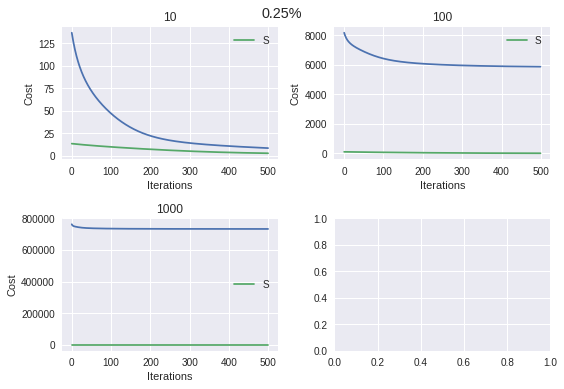

In [9]:
graphs_learning(.25, 5, 500)


In [0]:
graphs_learning(.50, 5, 500)


10


10

Cost: 30.705210

Cost: 28.264668

Cost: 26.132210

Cost: 24.237295

Cost: 22.529762

Cost: 10.842153

Cost: 10.338257

Cost: 9.872467

Cost: 9.437160

Cost: 9.026158
100

Cost: 2803.422607

Cost: 2671.046143

Cost: 2568.498779

Cost: 2479.883789

Cost: 2397.135986

Cost: 22.311451

Cost: 21.240084

Cost: 20.256573

Cost: 19.344818

Cost: 18.491882
1000

Cost: 253585.625000

Cost: 247547.718750

Cost: 244541.828125

Cost: 242034.578125

Cost: 239945.750000

Cost: 31.131216

Cost: 30.266052

Cost: 29.441872

Cost: 28.653246

Cost: 27.895449


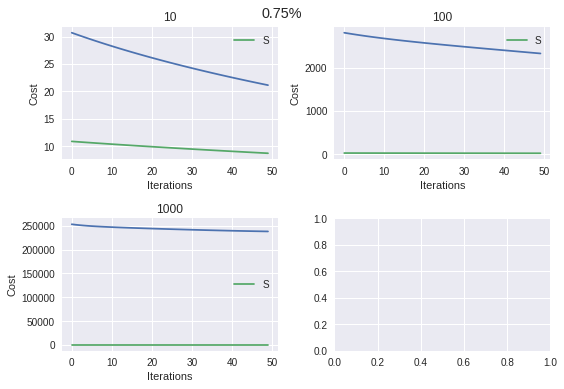

In [7]:
graphs_learning(.75, 5, 500)